In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cam = np.load("cameraman.npy")

In [3]:
print("Cameraman :", cam.shape, cam.dtype)

Cameraman : (256, 256) uint8


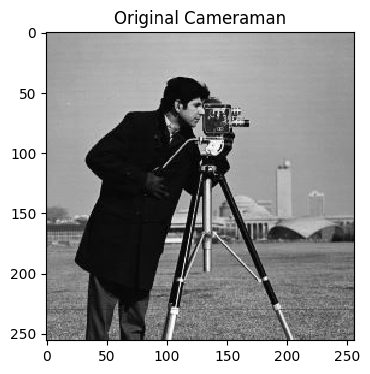

In [4]:
plt.figure(figsize=(4, 4))
plt.imshow(cam, cmap='gray', interpolation='nearest')
plt.title("Original Cameraman")
plt.axis('on')

plt.show()

In [5]:
def downsample_avg(img, factor):
    h, w = img.shape
    new_h = h // factor
    new_w = w // factor

    out = np.zeros((new_h, new_w), dtype=np.uint8)

    for i in range(new_h):
        for j in range(new_w):
            block_sum = 0.0   # 🔑 float accumulator
            count = 0

            for m in range(factor):
                for n in range(factor):
                    block_sum += float(img[i * factor + m, j * factor + n])
                    count += 1

            out[i, j] = int(round(block_sum / count))

    return out


In [6]:
cam_ds = downsample_avg(cam, factor = 2)
print("Downsampled shape:", cam_ds.shape)

Downsampled shape: (128, 128)


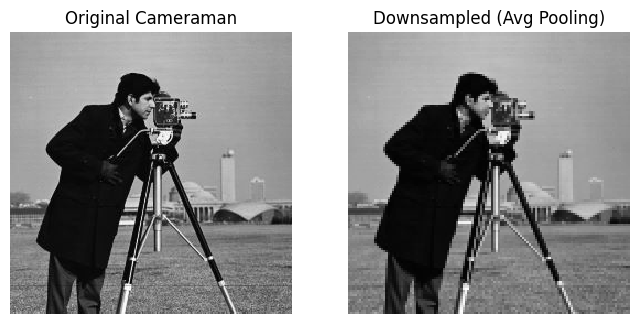

In [7]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(cam, cmap='gray', interpolation='nearest')
plt.title("Original Cameraman")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cam_ds, cmap='gray', interpolation='nearest')
plt.title("Downsampled (Avg Pooling)")
plt.axis('off')

plt.show()


In [8]:
def nn_resize(img, new_h, new_w):
    h, w = img.shape
    out = np.zeros((new_h, new_w), dtype=np.uint8)

    x_ratio = h / new_h
    y_ratio = w / new_w

    for i in range(new_h):
        for j in range(new_w):
            src_x = int(i * x_ratio)
            src_y = int(j * y_ratio)

            if src_x >= h:
                src_x = h - 1
            if src_y >= w:
                src_y = w - 1

            out[i, j] = img[src_x, src_y]

    return out


In [9]:
cam_nn = nn_resize(
    cam_ds,
    cam.shape[0],
    cam.shape[1]
)


In [10]:
cam_nn.shape

(256, 256)

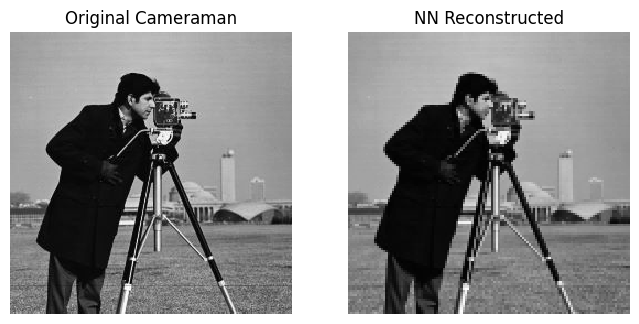

In [11]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(cam, cmap='gray', interpolation='nearest')
plt.title("Original Cameraman")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cam_nn, cmap='gray', interpolation='nearest')
plt.title("NN Reconstructed")
plt.axis('off')

plt.show()


In [12]:
def bilinear_resize(img, new_h, new_w):
    h, w = img.shape
    out = np.zeros((new_h, new_w), dtype=np.uint8)

    x_ratio = (h - 1) / new_h
    y_ratio = (w - 1) / new_w

    for i in range(new_h):
        for j in range(new_w):
            x = i * x_ratio
            y = j * y_ratio

            x0 = int(x)
            y0 = int(y)
            x1 = min(x0 + 1, h - 1)
            y1 = min(y0 + 1, w - 1)

            dx = x - x0
            dy = y - y0

            p00 = float(img[x0, y0])
            p10 = float(img[x1, y0])
            p01 = float(img[x0, y1])
            p11 = float(img[x1, y1])

            val = (
                (1 - dx) * (1 - dy) * p00 +
                dx * (1 - dy) * p10 +
                (1 - dx) * dy * p01 +
                dx * dy * p11
            )

            out[i, j] = int(round(val))

    return out


In [13]:
cam_bl = bilinear_resize(
    cam_ds,
    cam.shape[0],
    cam.shape[1]
)
cam_bl.shape


(256, 256)

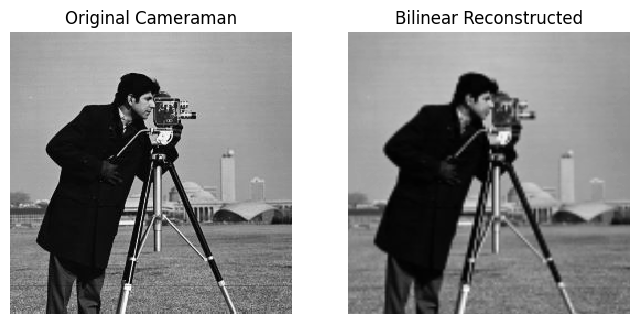

In [14]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(cam, cmap='gray', interpolation='nearest')
plt.title("Original Cameraman")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cam_bl, cmap='gray', interpolation='nearest')
plt.title("Bilinear Reconstructed")
plt.axis('off')

plt.show()


In [15]:
def cubic(x):
    x = abs(x)
    if x <= 1:
        return 1 - 2*x*x + x*x*x
    elif x < 2:
        return 4 - 8*x + 5*x*x - x*x*x
    else:
        return 0


In [16]:
def bicubic_resize(img, new_h, new_w):
    h, w = img.shape
    out = np.zeros((new_h, new_w), dtype=np.uint8)

    x_ratio = h / new_h
    y_ratio = w / new_w

    for i in range(new_h):
        for j in range(new_w):
            x = i * x_ratio
            y = j * y_ratio

            x_int = int(x)
            y_int = int(y)

            val = 0.0
            weight_sum = 0.0

            for m in range(-1, 3):
                for n in range(-1, 3):
                    xm = x_int + m
                    yn = y_int + n

                    # 🔑 CLAMP INDICES (MUST be integers)
                    if xm < 0:
                        xm = 0
                    elif xm >= h:
                        xm = h - 1

                    if yn < 0:
                        yn = 0
                    elif yn >= w:
                        yn = w - 1

                    wx = cubic(x - (x_int + m))
                    wy = cubic(y - (y_int + n))
                    weight = wx * wy

                    val += float(img[xm, yn]) * weight
                    weight_sum += weight

            if weight_sum != 0:
                val /= weight_sum

            # clamp to valid range
            if val < 0:
                val = 0
            elif val > 255:
                val = 255

            out[i, j] = int(round(val))

    return out


In [17]:
cam_bc = bicubic_resize(cam_ds, cam.shape[0], cam.shape[1])

cam_bc.shape


(256, 256)

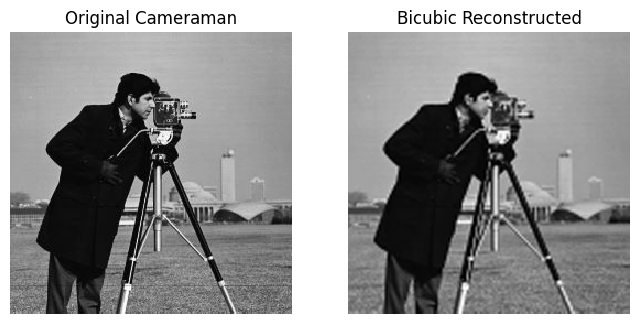

In [18]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(cam, cmap='gray', interpolation='nearest')
plt.title("Original Cameraman")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cam_bc, cmap='gray', interpolation='nearest')
plt.title("Bicubic Reconstructed")
plt.axis('off')

plt.show()


In [19]:
def psnr(img1, img2):
    h, w = img1.shape
    mse = 0.0

    for i in range(h):
        for j in range(w):
            diff = float(img1[i, j]) - float(img2[i, j])
            mse += diff * diff

    mse /= (h * w)

    if mse == 0:
        return float('inf')

    MAX = 255.0
    return 10 * np.log10((MAX * MAX) / mse)


In [20]:
psnr_nn = psnr(cam, cam_nn)
psnr_bl = psnr(cam, cam_bl)
psnr_bc = psnr(cam, cam_bc)

print("PSNR (Nearest Neighbor):", psnr_nn)
print("PSNR (Bilinear):", psnr_bl)
print("PSNR (Bicubic):", psnr_bc)


PSNR (Nearest Neighbor): 25.438398425037754
PSNR (Bilinear): 23.938376927058687
PSNR (Bicubic): 24.357278135626213


In [21]:
print("cam min/max:", cam.min(), cam.max())
print("cam_ds min/max:", cam_ds.min(), cam_ds.max())


cam min/max: 0 255
cam_ds min/max: 5 252


In [22]:
def mae(img1, img2):
    h, w = img1.shape
    err = 0.0

    for i in range(h):
        for j in range(w):
            err += abs(float(img1[i, j]) - float(img2[i, j]))

    return err / (h * w)


In [23]:
print("MAE NN:", mae(cam, cam_nn))
print("MAE Bilinear:", mae(cam, cam_bl))
print("MAE Bicubic:", mae(cam, cam_bc))


MAE NN: 6.060516357421875
MAE Bilinear: 7.7711029052734375
MAE Bicubic: 7.119049072265625
